In [9]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [105]:
df = pd.read_sql("count_contentieux_par_compte", index_col=0)

In [106]:
df.describe()
df.head()

,nb_ctx,nb_comptactifs_std,nb_comptes_factures_std,nb_comptes_recouvres_std,nb_debiteurs_std,nb_crediteurs_std,nb_a_zero_std,mnt_ttc_facture_ccl_std,mnt_tva_facture_ccl_std,mnt_ttc_echeance_std,...,compte_client_ref,compte_client_ref_aff,compte_client_ind_fin_gestion,compte_client_dtdact,compte_client_dtfact,compte_client_datdep,compte_client_mnt_nv_chg,compte_client_mnt_nv_prd,compte_client_ind_parti,compte_client_origine_pgi
0,42,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.00,...,KSP||800011,800011,0,2011-04-01,NaN,2012-12-31,0.0,0.0,1.0,ikos
1,1,1.0,1.0,1.0,0.0,1.0,0.0,528.85,0.0,528.85,...,KSP||800012,800012,0,2011-04-01,NaN,NaN,0.0,0.0,0.0,ikos
2,8,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.00,...,KSP||800013,800013,0,2011-04-01,NaN,2012-06-30,0.0,0.0,1.0,ikos
3,0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.00,...,KSP||800014,800014,0,2011-04-01,NaN,2011-10-03,0.0,0.0,1.0,ikos
4,0,1.0,1.0,0.0,0.0,1.0,0.0,111.85,0.0,528.85,...,KSP||800015,800015,0,2011-06-15,NaN,NaN,0.0,0.0,0.0,ikos


### Missing data

remove columns with only missing data.

In [107]:
df.dropna(axis=1, how='all', inplace=True)

In [108]:
df.isna().sum()/len(df)

nb_ctx                       0.00000
nb_comptactifs_std           0.00000
nb_comptes_factures_std      0.00000
nb_comptes_recouvres_std     0.00000
nb_debiteurs_std             0.00000
                              ...   
compte_client_datdep         0.83424
compte_client_mnt_nv_chg     0.00000
compte_client_mnt_nv_prd     0.00000
compte_client_ind_parti      0.00000
compte_client_origine_pgi    0.00000
Length: 65, dtype: float64

We impute the missing data usin univariate statistic. We replace missing values by the median of the column. It is very important: Choosing mean and you will lose a lot of prediction because the data is unbalanced.

In [109]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy="median")
df_numeric = df._get_numeric_data()
print(df_numeric.shape)
imp.fit(df_numeric)
idf = pd.DataFrame(imp.transform(df_numeric))
print(idf.shape)
idf.columns=df_numeric.columns
idf.index=df_numeric.index
df.update(idf)
df._get_numeric_data().isna().sum()/len(df._get_numeric_data())

(100000, 46)
(100000, 46)


nb_ctx                           0.0
nb_comptactifs_std               0.0
nb_comptes_factures_std          0.0
nb_comptes_recouvres_std         0.0
nb_debiteurs_std                 0.0
nb_crediteurs_std                0.0
nb_a_zero_std                    0.0
mnt_ttc_facture_ccl_std          0.0
mnt_tva_facture_ccl_std          0.0
mnt_ttc_echeance_std             0.0
mnt_tva_echeance_std             0.0
mnt_loyer_ccl_std                0.0
mnt_charges_ccl_std              0.0
mnt_caution_dg_ccl_std           0.0
mnt_aides_ccl_std                0.0
mnt_sls_ccl_std                  0.0
mnt_solde_charges_ccl_std        0.0
mnt_autres_ccl_std               0.0
mnt_total_encaisse_std           0.0
solde_std                        0.0
solde_crediteur_std              0.0
solde_debiteur_std               0.0
dette_du_mois_std                0.0
dette_moins_3mois_std            0.0
dette_plus_3_a_6_mois_std        0.0
dette_plus_6_a_12_mois_std       0.0
dette_plus_12_mois_std           0.0
n

### Exploration

We can see that around 60% of accounts do have at least one contentieu.

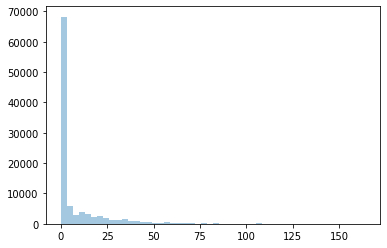

In [110]:
fig, ax = plt.subplots()
ax = sns.distplot(x=df.nb_ctx, kde=False)

In [111]:
df.nb_ctx[df.nb_ctx==0].shape

(60346,)

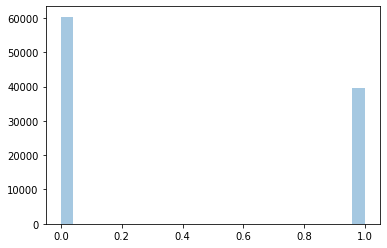

In [112]:
df["existence_ctx"] = (df.nb_ctx>0).astype('int64', copy=False)
fig, ax = plt.subplots()
ax = sns.distplot(x=df.existence_ctx, kde=False)

In [113]:
df["existence_ctx"].head()

0    1
1    1
2    1
3    0
4    0
Name: existence_ctx, dtype: int64

Let's plot spearman's correlations

<AxesSubplot:>

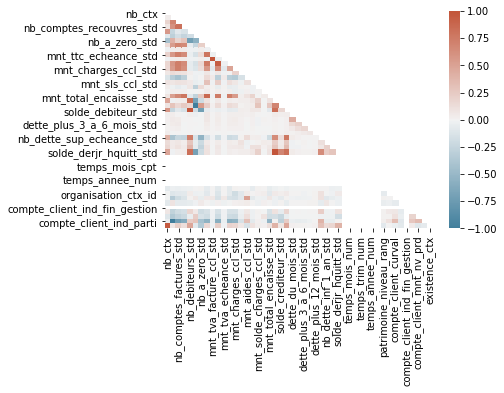

In [129]:
corr  = df.corr('spearman')
sns.heatmap(
    corr, 
    mask=np.triu(np.ones_like(corr, dtype=bool)), 
    cmap = sns.diverging_palette(230, 20, as_cmap=True),
    center=0,
    )

In [130]:
fig, ax = plt.subplots(1,1)
plt.title("correlations")
corr = corr.sort_values(
    by=['existence_ctx'],
    ascending=False,
    key=abs
    )
ax = sns.barplot(
    corr.index[2:25], # !!!! 2 because existence is built from count
    corr.existence_ctx[2:25]
)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'solde_debiteur_std'),
  Text(1, 0, 'nb_debiteurs_std'),
  Text(2, 0, 'solde_std'),
  Text(3, 0, 'solde_derjr_hquitt_std'),
  Text(4, 0, 'nb_a_zero_std'),
  Text(5, 0, 'nb_dette_sup_echeance_std'),
  Text(6, 0, 'nb_comptes_factures_std'),
  Text(7, 0, 'mnt_ttc_echeance_std'),
  Text(8, 0, 'mnt_loyer_ccl_std'),
  Text(9, 0, 'mnt_charges_ccl_std'),
  Text(10, 0, 'nb_nouveaux_en_dette_std'),
  Text(11, 0, 'mnt_ttc_facture_ccl_std'),
  Text(12, 0, 'nb_dette_inf_1_an_std'),
  Text(13, 0, 'mnt_aides_ccl_std'),
  Text(14, 0, 'nb_comptes_recouvres_std'),
  Text(15, 0, 'mnt_total_encaisse_std'),
  Text(16, 0, 'mnt_sls_ccl_std'),
  Text(17, 0, 'compte_client_mnt_nv_prd'),
  Text(18, 0, 'solde_crediteur_std'),
  Text(19, 0, 'nb_crediteurs_std'),
  Text(20, 0, 'patrimoine_niveau_rang'),
  Text(21, 0, 'compte_client_ref_aff'),
  Text(22, 0, 'mnt_caution_dg_ccl_std')])

### feature selection

We select the K features that have the higest score on the anova test. It test if the features have the same means. scores high when the means are significatively different.

In [146]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from scipy.stats import chi2_contingency

In [161]:


features = [c for c in df.columns if c not in {"nb_ctx", "existence_ctx"} and '_id' not in c]
X = df[features]._get_numeric_data()


y=df["existence_ctx"]
X.shape

# Create and fit selector
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_selected = X.iloc[:,cols]
X_selected.head()

,nb_comptes_factures_std,nb_debiteurs_std,nb_a_zero_std,mnt_ttc_echeance_std,mnt_aides_ccl_std,solde_std,solde_debiteur_std,nb_dette_sup_echeance_std,nb_nouveaux_en_dette_std,solde_derjr_hquitt_std
0,0.0,1.0,0.0,0.00,0.0,9551.42,9551.42,1.0,0.0,9551.42
1,1.0,0.0,0.0,528.85,0.0,-81.18,0.00,0.0,0.0,-81.18
2,0.0,1.0,0.0,0.00,0.0,3493.75,3493.75,1.0,0.0,3493.75
3,0.0,1.0,0.0,0.00,0.0,2934.54,2934.54,1.0,0.0,2934.54
4,1.0,0.0,0.0,528.85,-417.0,-653.09,0.00,0.0,0.0,-653.09


### Classification

In [162]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=1)

In [164]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8937


In [165]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

### ccp_apha tuning
Selecting ccp_apha for effective prunning. It removes recursively the separation that gives the least information. 

Le critère de coût-complexitéCα(T) est coût de mauvais classement de T pénalisé par la complexité de l’arbre :
Cα(T) =nR(T) +α| ̃T|,où-| ̃T|est le nombre de noeuds terminaux deT,-nR(T)est le nombre de mal classés (pour une fonction de coût 0-1) et le coûtde mauvais classement (pour une fonction de coût quelconque).Pour une valeur fixée du paramètreα, on voudra minimiserCα(T)

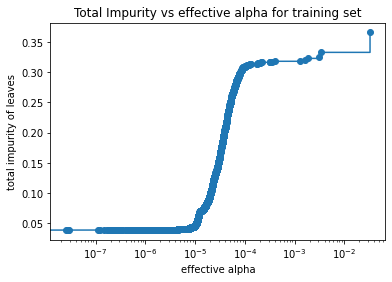

In [166]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
ax.set_xscale("log")

In [167]:
ccp_alphas[0]

0.0

In [168]:
clfs = []
ccp_alphas = np.linspace(1e-8, 1e-04, 10)
for ccp_alpha in ccp_alphas:
    print(ccp_alpha)
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

1e-08
1.112e-05
2.2230000000000002e-05
3.334e-05
4.445e-05
5.556e-05
6.667e-05
7.778e-05
8.889e-05
0.0001
Number of nodes in the last tree is: 131 with ccp_alpha: 0.0001


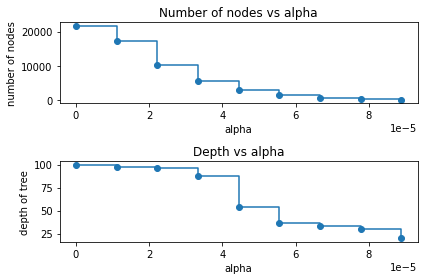

In [169]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

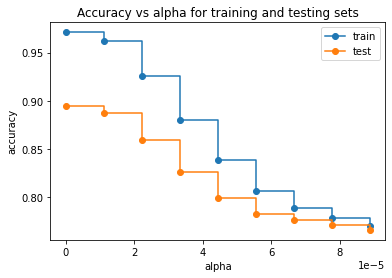

In [170]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

### Visualization

Pour visualiser, on prend alpha grand.

In [173]:
dot_data = StringIO()
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.002)
clf.fit(X_train, y_train)
export_graphviz(
    clf, 
    out_file=dot_data,  
    filled=True,
    special_characters=True,
    feature_names = X_selected.columns,
    class_names=['😇 pas ctx','🧾 ctx']
    )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ctx_10_features.png')
print(clf.score(X_test, y_test))
Image(graph.create_png())

0.7557


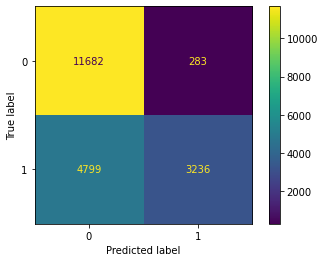

In [145]:
metrics.plot_confusion_matrix(clf, X_test, y_test)